In [4]:
import numpy as np
import os, glob
from keras.preprocessing import image as kImage
from skimage.transform import pyramid_gaussian
from keras.models import load_model
import matplotlib.pyplot as plt
from my_upsampling_2d import MyUpSampling2D
def getData(input_path):
    X = []
    for p in input_path:
        x = kImage.load_img(p)
        x = kImage.img_to_array(x)
        X.append(x)
    X = np.asarray(X)

    s1 = X
    del X
    s2 = []
    s3 = []
    for x in s1:
       pyramid = tuple(pyramid_gaussian(x/255., max_layer=2, downscale=2))
       s2.append(pyramid[1]*255.)
       s3.append(pyramid[2]*255.)
    s2 = np.asarray(s2)
    s3 = np.asarray(s3)
    
    return [s1, s2, s3]

Using TensorFlow backend.
d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\users\admin

In [62]:
# get data
input_path = glob.glob(os.path.join('sample_test_frames', 'baoguoQD', '*.jpg')) # path to your test frames
data = getData(input_path)
print (data[0].shape, data[1].shape, data[2].shape)

d:\users\administrator\anaconda3\envs\python36\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


(1943, 240, 128, 3) (1943, 120, 64, 3) (1943, 60, 32, 3)


In [63]:
import tensorflow as tf
import keras.backend as K
def loss(y_true, y_pred):
    void_label = -1.
    y_pred = K.reshape(y_pred, [-1])
    y_true = K.reshape(y_true, [-1])
    idx = tf.where(tf.not_equal(y_true, tf.constant(void_label, dtype=tf.float32)))
    y_pred = tf.gather_nd(y_pred, idx) 
    y_true = tf.gather_nd(y_true, idx)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

# Segment on a single CPU for this test

# a sample FgSegNet_M model can be downloaded at https://drive.google.com/open?id=1KiEChAxuweEZHwqT5HrkTCbSjT9MxwUF
mdl_path = 'mdl_baoguoQD.h5'

model = load_model(mdl_path, custom_objects={'MyUpSampling2D': MyUpSampling2D,
                                            'loss':loss}) # load the saved model that is trained with 50 frames
probs = model.predict(data, batch_size=1, verbose=1)
probs = probs.reshape([probs.shape[0], probs.shape[1], probs.shape[2]])

d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1943/1943 [==============================] - ETA: 11:1 - ETA: 3:1 - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 57 - ETA: 57 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - E

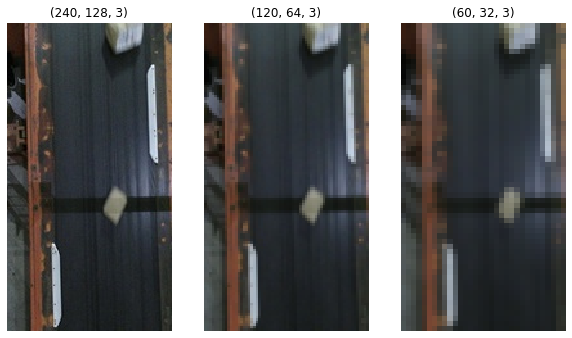

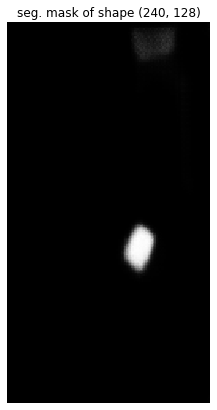

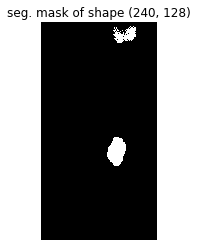

In [65]:
# plot the first segmentation mask

# plot last frame in 3 diff scales
num_in_row = 1
num_in_col = 3




frame_idx =1211# display frame index

plt.rcParams['figure.figsize'] = (10.0, 7.0) # set figure size

for i in range(num_in_row * num_in_col):
    x = data[i][frame_idx]
    plt.subplot(num_in_row, num_in_col, i+1)
    plt.imshow(x.astype('uint8'))
    
    plt.title(x.shape)
    plt.axis('off')
    
plt.show()
x = probs[frame_idx]

plt.subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(x)

plt.title('seg. mask of shape ' + str(x.shape))
plt.axis('off')
plt.show()
# Thresholding (one can specify any threshold values)
threshold = 0.1
x[x<threshold] = 0.
x[x>=threshold] = 1.

plt.subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(x)

plt.title('seg. mask of shape ' + str(x.shape))
plt.axis('off')
plt.show()


In [66]:
import cv2
import tqdm
for frame_idx in tqdm.tqdm(range(1943)):
    oral = data[0][frame_idx].astype(np.uint8).copy()
    xx = probs[frame_idx]*255
    xx = xx.astype(np.uint8)
    image=cv2.add(oral, np.zeros(np.shape(oral), dtype=np.uint8), mask=xx)
#     print(oral.shape)
#     print(image.shape)
    result = np.hstack((image,oral))
    cv2.imwrite("C:\\Users\\Administrator\\Desktop\\ZP\\FgSegNet-master2\\result\\"+str(frame_idx)+".png",result)
#     plt.imshow(result.astype('uint8'))

100%|█████████████████████████████████████████████████████████████████████████████| 1943/1943 [00:05<00:00, 379.64it/s]


In [1]:
import os
import cv2
import numpy as np
from ReSize import transferAndRoi
from matplotlib import pyplot as plt
import tqdm
import numpy as np
import os, glob
from keras.preprocessing import image as kImage
from skimage.transform import pyramid_gaussian
from keras.models import load_model
import matplotlib.pyplot as plt
from my_upsampling_2d import MyUpSampling2D
def getData(input_path):
    X = []
    for p in input_path:
        x = kImage.load_img(p)
        x = kImage.img_to_array(x)
        X.append(x)
    X = np.asarray(X)

    s1 = X
    del X
    s2 = []
    s3 = []
    for x in s1:
       pyramid = tuple(pyramid_gaussian(x/255., max_layer=2, downscale=2))
       s2.append(pyramid[1]*255.)
       s3.append(pyramid[2]*255.)
    s2 = np.asarray(s2)
    s3 = np.asarray(s3)
    
    return [s1, s2, s3]

Using TensorFlow backend.
d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\users\admin

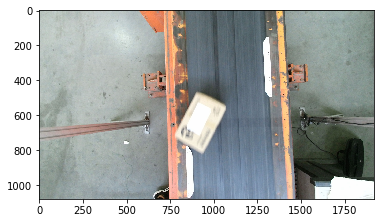

In [2]:
_10mmlist = os.listdir("10mm")
t = _10mmlist[11]
  
timg = kImage.load_img("10mm/"+t)
timg = kImage.img_to_array(timg)
plt.imshow(timg.astype('uint8'))


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:15<00:00, 17.13it/s]


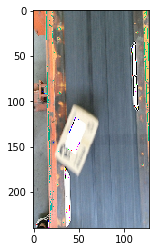

In [3]:
timgTrans = transferAndRoi(timg)
plt.imshow(timgTrans.astype('uint8'))
if not os.path.exists("10mm_result"):
    os.mkdir("10mm_result")
for i in tqdm.tqdm(_10mmlist):
    ttimgs = cv2.imread("10mm/"+i)
    ttimgs = transferAndRoi(ttimgs)
    cv2.imwrite("10mm_result/"+i,ttimgs)

In [4]:
input_path = glob.glob(os.path.join('10mm_result','*.jpg')) # path to your test frames
data = getData(input_path)
import tensorflow as tf
import keras.backend as K
def loss(y_true, y_pred):
    void_label = -1.
    y_pred = K.reshape(y_pred, [-1])
    y_true = K.reshape(y_true, [-1])
    idx = tf.where(tf.not_equal(y_true, tf.constant(void_label, dtype=tf.float32)))
    y_pred = tf.gather_nd(y_pred, idx) 
    y_true = tf.gather_nd(y_true, idx)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

# Segment on a single CPU for this test

# a sample FgSegNet_M model can be downloaded at https://drive.google.com/open?id=1KiEChAxuweEZHwqT5HrkTCbSjT9MxwUF
mdl_path = 'mdl_baoguoQD.h5'

model = load_model(mdl_path, custom_objects={'MyUpSampling2D': MyUpSampling2D,
                                            'loss':loss}) # load the saved model that is trained with 50 frames
probs = model.predict(data, batch_size=1, verbose=1)
probs = probs.reshape([probs.shape[0], probs.shape[1], probs.shape[2]])

d:\users\administrator\anaconda3\envs\python36\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


d:\users\administrator\anaconda3\envs\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


270/270 [==============================] - ETA: 29:0 - ETA: 14:3 - ETA: 9:4 - ETA: 7: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - E

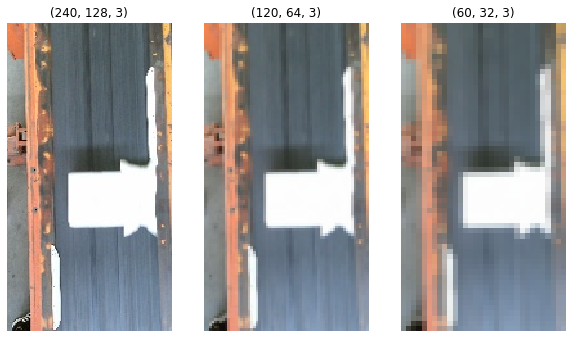

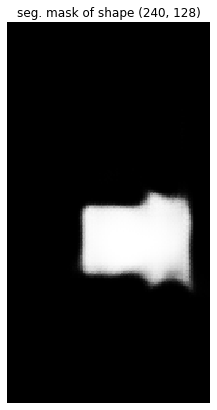

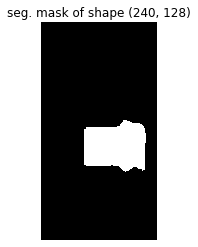

In [4]:
# plot the first segmentation mask

# plot last frame in 3 diff scales
num_in_row = 1
num_in_col = 3




frame_idx =12# display frame index

plt.rcParams['figure.figsize'] = (10.0, 7.0) # set figure size

for i in range(num_in_row * num_in_col):
    x = data[i][frame_idx]
    plt.subplot(num_in_row, num_in_col, i+1)
    plt.imshow(x.astype('uint8'))
    
    plt.title(x.shape)
    plt.axis('off')
    
plt.show()
x = probs[frame_idx]

plt.subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(x)

plt.title('seg. mask of shape ' + str(x.shape))
plt.axis('off')
plt.show()
# Thresholding (one can specify any threshold values)
threshold = 0.5
x[x<threshold] = 0.
x[x>=threshold] = 1.

plt.subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(x)

plt.title('seg. mask of shape ' + str(x.shape))
plt.axis('off')
plt.show()


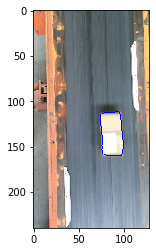

In [13]:
frame_idx = 111
mask = probs[frame_idx].copy()
mask[mask>threshold] = 255
mask[mask<threshold] = 0
x = data[0][frame_idx].copy()

contours, hierarchy = cv2.findContours(mask.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
    # print(len(contours))
    # print(contours)
cv2.drawContours(x,contours,-1,(0,0,255),1)  
plt.imshow(x.astype('uint8'))

In [11]:
if not os.path.exists("10mmresult"):
    os.mkdir("10mmresult")
for frame_idx in tqdm.tnrange(data[0].shape[0]):
    x = data[0][frame_idx].copy()
    result = x.copy()
    for thres in range(1,10):
        tx = x.copy()
        threshold = thres * 0.1
        mask = probs[frame_idx].copy()
        mask[mask>threshold] = 255
        mask[mask<threshold] = 0
        contours, hierarchy = cv2.findContours(mask.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
        cv2.drawContours(tx,contours,-1,(255,0,0),1) 
        result = np.hstack((result,tx))
    result = cv2.cvtColor(result,cv2.COLOR_RGB2BGR)
    cv2.imwrite("10mmresult/"+str(frame_idx)+".jpg",result)